## 1. Create Environment

In [1]:
#Import Library
import numpy as np
import pandas as pd
from sklearn import preprocessing
import random as r
import copy
import time
from tqdm import tqdm

#Use Tensorflow-Keras
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6,7"
from keras.models import Model
from keras.layers import Input, Dense, concatenate, Flatten, Dropout
from keras.layers import LSTM, Bidirectional, GRU
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K
from matplotlib import pyplot

#Use Sklearn for evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr 
import scipy.stats as stats
from scipy.special import expit

#Add
import random
import matplotlib.pyplot as plt

## 2. Data Loader and preprocessing

In [2]:
# Load Data
raw_csv_data=pd.read_csv(r"ESTC Denorm.csv")
df=raw_csv_data.copy()

# Normalize
x = df.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x)

# For training + validation 60% + 20% = 80% or 0.8
split = df.shape[0]*0.8
# the training and validation will be splited later in the model compiler

train_dataset = df.loc[:split, :]
test_dataset = df.loc[split:, :]
print(train_dataset.shape, test_dataset.shape)

# Split Time-independent Variables Input for NN
train_xi = train_dataset.loc[:,1:14]
test_xi = test_dataset.loc[:,1:14]

print(train_xi.shape)
print(test_xi.shape)

# Split Time-dependent Variables Input for BiGRU
train_xg = train_dataset.loc[:,15:]
test_xg = test_dataset.loc[:,15:]

print(train_xg.shape)
print(test_xg.shape)

# Reshape input data dimension from 2D to 3D for BiGRU input
train_xd = train_xg.values.reshape(train_xg.shape[0], 3, 5) # (batch size, timesteps, features)
test_xd = test_xg.values.reshape(test_xg.shape[0], 3, 5) # (batch size, timesteps, features)
print(train_xd.shape, test_xd.shape)

# Output or Target Variable
train_y = train_dataset.iloc[:,0]
test_y = test_dataset.iloc[:,0]
print(train_y.shape)
print(test_y.shape)

(181, 30) (45, 30)
(181, 14)
(45, 14)
(181, 15)
(45, 15)
(181, 3, 5) (45, 3, 5)
(181,)
(45,)


## 3. OMA-NN-BiGRU Model

Author : Frederik Elly Gosal
    
    Always make the input for the model as follows:

    For NN (Time-Independent) (none, features):
    Training variables: train_xi.
        Test variables: test_xi.
    
    For GRU (Time-Dependent) (none, timesteps, features):
    Training variables: train_xd.
        Test variables: test_xd.
    
    For output :
    Training variables: train_y.
        Test variables: test_y.

### 3.1 Optimize the Model Architecture

Loading...:   0%|          | 0/10 [00:00<?, ?it/s]2025-04-28 13:02:49.852034: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-28 13:02:51.734215: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22351 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:81:00.0, compute capability: 8.6
2025-04-28 13:02:51.736470: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22351 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:a1:00.0, compute capability: 8.6
2025-04-28 13:02:51.738527: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created dev

CPU times: user 3h 53min 57s, sys: 1h 23min 48s, total: 5h 17min 46s
Wall time: 4h 9min 38s


Text(0, 0.5, 'Objective function value')

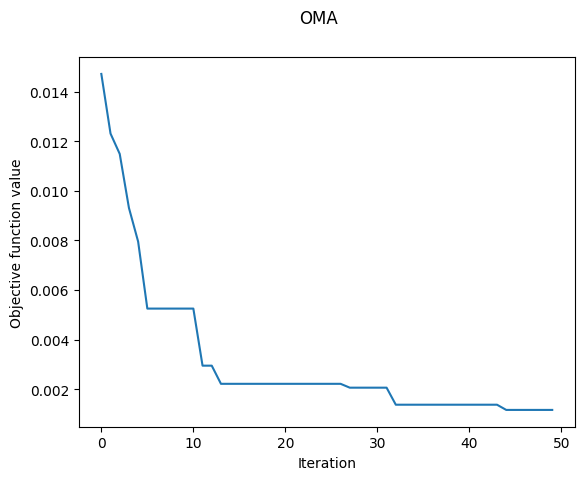

In [ ]:
%%time
def objfun(x):
    nn_neurons = int(x[0])
    transformer_head_size = int(x[1])
    transformer_num_heads = int(x[2])
    transformer_ff_dim = int(x[3])
    nn_dense_neurons = int(x[4])
    transformer_dropout = x[5]
    nn_dropout_rate = x[6]
    lr = x[7]

    # NN-Transformer Model
    
    # Transformer
    transformer_input = Input(shape=(train_xd.shape[1], train_xd.shape[2]), name='Left_input')
    x = Dense(64)(transformer_input)  # Project to a higher dimension
    pos_encoding = PositionalEncoding(position=train_xd.shape[1], d_model=64)(x)
    for _ in range(2):  # Fixed number of layers for simplicity
        x = transformer_block(x, head_size=transformer_head_size, num_heads=transformer_num_heads, 
                             ff_dim=transformer_ff_dim, dropout=transformer_dropout)
    transformer_output = Dense(1)(x[:, -1, :])  # Last timestep output

    # NN
    dnn_input = Input(shape=(train_xi.shape[1]), name='Right_input')
    dnn_layer = Dense(nn_neurons, activation='relu')(dnn_input)
    dnn_layer = Dropout(nn_dropout_rate)(dnn_layer)
    dnn_layer = Dense(nn_neurons, activation='relu')(dnn_layer)
    dnn_layer = Dropout(nn_dropout_rate)(dnn_layer)
    dnn_dense = Dense(nn_dense_neurons, activation='linear')(dnn_layer)

    # Combine the output using Concatenation (concat layer)
    concat = concatenate([transformer_output, dnn_dense], name='Concatenate')
    final_model_output = Dense(1, activation='sigmoid')(concat)
    final_model = Model(inputs=[transformer_input, dnn_input], outputs=final_model_output,
                        name='Final_output')
    
    # Train the model and return val_loss as Objective function
    final_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='mse')
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
    history = final_model.fit([train_xd, train_xi], train_y, epochs=1000, batch_size=train_y.shape[0], 
                          validation_data=([test_xd, test_xi], test_y), shuffle=False, verbose=0, callbacks=[callback])
    
    K.clear_session()
    fit = np.min(history.history['val_loss'])
    return fit

nVar = 8  # number of variables
Ub = np.array([200, 128, 8, 256, 20, 0.5, 0.5, 0.1])  # nn_neurons, head_size, num_heads, ff_dim, nn_dense_neurons, transformer_dropout, nn_dropout_rate, lr
Lb = np.array([5, 16, 2, 32, 1, 0.0, 0.0, 0.0001])

#### 3.1.1 Print the optimal Architecture Parameter

In [7]:
print("MSE = {:.6f}" .format(bestmag[0]))

print(' ')

print("Optimal Parameters:")
print("NN Number of Neurons           = {:.0f}" .format(int(bestsol[0])))
print("BiGRU Number of Units          = {:.0f}" .format(int(bestsol[1])))
print("NN Dense Number of Neurons     = {:.0f}" .format(int(bestsol[2])))
print("BiGRU Dense Number of Neurons  = {:.0f}" .format(int(bestsol[3])))
print("NN Dropout Rate                = {:.4f}" .format(bestsol[4]))
print("BiGRU Dropout Rate             = {:.4f}" .format(bestsol[5]))
print("Learning Rate                  = {:.4f}" .format(bestsol[6]))

MSE = 0.001169
 
Optimal Parameters:
NN Number of Neurons           = 5
BiGRU Number of Units          = 49
NN Dense Number of Neurons     = 6
BiGRU Dense Number of Neurons  = 6
NN Dropout Rate                = 0.0000
BiGRU Dropout Rate             = 0.3664
Learning Rate                  = 0.0231


In [8]:
# These are the actual optimal dropout rate and learning rate value used in Optimized Inference Model
print("NN Dropout Rate     = ", bestsol[4])
print("BiGRU Dropout Rate  = ", bestsol[5])
print("Learning Rate       = ", bestsol[6])

NN Dropout Rate     =  0.0
BiGRU Dropout Rate  =  0.36638481417665564
Learning Rate       =  0.02308606386663337


#### 3.1.2 Train the model with Optimal Architecture

Epoch 1/500
1/1 [==============================] - ETA: 0s - loss: 0.0679
Epoch 1: val_loss improved from inf to 0.24358, saving model to best_weights.hdf5
1/1 [==============================] - 5s 5s/step - loss: 0.0679 - val_loss: 0.2436
Epoch 2/500
1/1 [==============================] - ETA: 0s - loss: 0.2423
Epoch 2: val_loss improved from 0.24358 to 0.02722, saving model to best_weights.hdf5
1/1 [==============================] - 0s 74ms/step - loss: 0.2423 - val_loss: 0.0272
Epoch 3/500
1/1 [==============================] - ETA: 0s - loss: 0.0337
Epoch 3: val_loss did not improve from 0.02722
1/1 [==============================] - 0s 62ms/step - loss: 0.0337 - val_loss: 0.0702
Epoch 4/500
1/1 [==============================] - ETA: 0s - loss: 0.0686
Epoch 4: val_loss did not improve from 0.02722
1/1 [==============================] - 0s 54ms/step - loss: 0.0686 - val_loss: 0.0285
Epoch 5/500
1/1 [==============================] - ETA: 0s - loss: 0.0300
Epoch 5: val_loss did not 

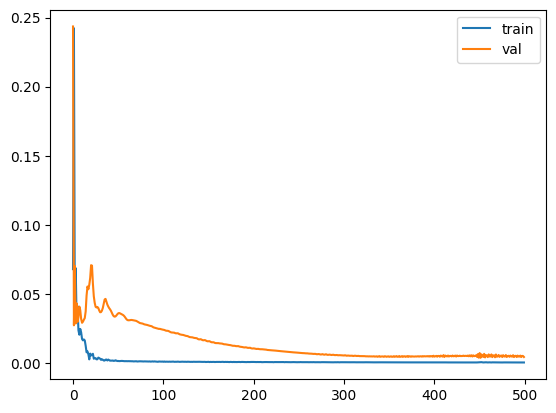

CPU times: user 35 s, sys: 13.6 s, total: 48.6 s
Wall time: 37.2 s


In [9]:
%%time
nn_neurons = int(bestsol[0])
bigru_units = int(bestsol[1])
nn_dense_neurons = int(bestsol[2])
bigru_dense_neurons = int(bestsol[3])
nn_dropout_rate = bestsol[4]
bigru_dropout_rate = bestsol[5]
lr = bestsol[6]

# NN-BiGRU Model
    
# BiGRU
gru_input = Input(shape=(train_xd.shape[1],train_xd.shape[2]) , name='Left_input')
gru_layer = Bidirectional(GRU(bigru_units, activation='tanh', return_sequences=True))(gru_input)
gru_layer = Dropout(bigru_dropout_rate)(gru_layer)
gru_layer = Bidirectional(GRU(bigru_units, activation='tanh', return_sequences=False))(gru_layer)
gru_layer = Dropout(bigru_dropout_rate)(gru_layer)
gru_dense = Dense(bigru_dense_neurons, activation='linear')(gru_layer)

# NN
dnn_input = Input(shape=(train_xi.shape[1]), name='Right_input')
dnn_layer = Dense(nn_neurons, activation='relu')(dnn_input)
dnn_layer = Dropout(nn_dropout_rate)(dnn_layer)
dnn_layer = Dense(nn_neurons, activation='relu')(dnn_layer)
dnn_layer = Dropout(nn_dropout_rate)(dnn_layer)
dnn_dense = Dense(nn_dense_neurons, activation='linear')(dnn_layer)

# Combine the ouput using Concatenation (concat layer)
concat = concatenate([gru_dense, dnn_dense], name='Concatenate')
final_model_output = Dense(1, activation='sigmoid')(concat)
final_model = Model(inputs=[gru_input, dnn_input], outputs=final_model_output,
                        name='Final_output')
    

final_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='mse')

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_weights.hdf5', 
                             save_best_only=True,
                             save_weights_only=True,
                             monitor='val_loss', 
                             mode='min', 
                             verbose=1)

history = final_model.fit([train_xd, train_xi], train_y, epochs=500, batch_size=train_y.shape[0], 
                          validation_data=([test_xd, test_xi], test_y),callbacks=[checkpoint], shuffle=False)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

### 3.2 Optimize the Output Weights

In [10]:
# Load best weights to the model
final_model.load_weights('best_weights.hdf5')
y_pred = final_model.predict([test_xd, test_xi])

In [11]:
# Get the neuron output in concat layer
concat_model = Model(inputs=final_model.input, outputs=final_model.get_layer('Concatenate').output)
concatenated_output = concat_model.predict([train_xd, train_xi])
print(concatenated_output.shape) # (number of train-data, num of neuron)

(181, 12)


## NOTE*
If the output is not satisfying, it is due to the output weights are stuck at the local best solution.

Therefore, to get better result you need to run the OMA again from this section by click this section box, click cell on the menu bar, then click run all below.

Do the above mentioned steps until you are satisfied with the result :) 

In [12]:
data = concatenated_output
targets = train_y.values.reshape(-1)

def fitness(weights, data, targets):
    predictions = expit(np.dot(data, weights)) # sigmoid function applied
    error = np.mean((targets - predictions) ** 2.0) # MSE
    return error

def objfun1(weights):
    return fitness(weights, data, targets)

def rangeCheck(x):
    for i in range(0,x.size):
        if x[i]<Lb1:
            x[i]=Lb1
        if x[i]>Ub1:
            x[i]=Ub1
            
nVar1=concatenated_output.shape[1]
Ub1=1
Lb1=-1
maxiter1=100
npop1=100

# Credit:
# The Optical Microscope Algorithm: A Novel Metaheuristic Inspired by Microscope Magnification
# Author and programmer:                                                  
#          Professor        Min-Yuan Cheng                                   
#          Ph.D. Student    Moh Nur Sholeh                                   
#   Written by Moh Nur Sholeh                                                
#   Computer Integrated Construction (CIC) Lab                               
#   National Taiwan University of Science and Technology, Taipei, Taiwan

#1 Naked eye phase
x=np.zeros((npop1,nVar1))
fit=np.zeros((npop1,1))
x[0,]=np.random.rand(1,nVar1)
for i in range(1,npop1):
    x[i,]=x[i-1,]*(1-x[i-1,])
    
for i in range(0,npop1):
    x[i,]=Lb1+x[i,]*(Ub1-Lb1)
    fit[i,]=objfun1(x[i,])

#OMA Main Loop
for it in range(0, maxiter1):
    idx=np.argmin(fit)
    bestsol1=x[idx,]
    bestmag1=fit[idx,]
#     print("Iter {}: {}".format(it,bestmag1))
    for i in range(0,npop1):
        #2 Objective Lens Phase
        xnew=bestsol1+np.random.rand(nVar1)*1.4*(x[i,])
        rangeCheck(xnew)
        fitnew=objfun1(xnew)
        if fitnew<fit[i,]:
            fit[i,]=fitnew
            x[i,]=xnew
        
        #3 Eyepiece phase
        j=r.randrange(0,npop1)
        while j==i:
            j=r.randrange(0,npop1)
        if fit[i,]>=fit[j,]:
            space=x[j,]-x[i,]
        else :
            space=x[i,]-x[j,]
        xnew=x[i,]+np.random.rand(nVar1)*(0.55*space)
        rangeCheck(xnew)
        fitnew=objfun1(xnew)
        if fitnew<fit[i,]:
            fit[i,]=fitnew
            x[i,]=xnew
            
idx=np.argmin(fit)
bestsol1=x[idx,]
bestmag1=fit[idx,]
print(bestsol1)
print("Train_MSE:", bestmag1)

[-1.  1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1.]
Train_MSE: [0.00817262]


#### 3.2.1 Print the optimal output weight

In [13]:
for i, weight in enumerate(bestsol1):
    print("W{} = {:.6f}".format(i+1, weight))
    
sum_matrix = np.sum(bestsol1)
print("The sum of the weight:", sum_matrix)

W1 = -1.000000
W2 = 1.000000
W3 = -1.000000
W4 = -1.000000
W5 = -1.000000
W6 = 1.000000
W7 = -1.000000
W8 = -1.000000
W9 = -1.000000
W10 = -1.000000
W11 = -1.000000
W12 = -1.000000
The sum of the weight: -8.0


### 3.3 Make Prediction Using Optimized Model

In [14]:
#Predict using the testing dataset
y_out_concat = concat_model.predict([test_xd, test_xi])
y_pred_OMA = expit(np.dot(y_out_concat, bestsol1))
print(y_pred_OMA.shape)

(45,)


## 4. Performance Evaluation

In [15]:
# Denormalize Output
max_y = 1 # target variable's maximum value from whole dataset
min_y = 0 # target variable's minimum value from whole dataset

test_y_act = test_y * (max_y - min_y) + min_y
test_y_act = test_y_act.values.reshape(-1)
y_pred_OMA_act = y_pred_OMA * (max_y - min_y) + min_y
y_pred_OMA_act = y_pred_OMA_act.reshape(-1)
y_pred_act = y_pred * (max_y - min_y) + min_y
y_pred_act = y_pred_act.reshape(-1)

# act means actual value, the denormalized value

In [19]:
# Evaluation Metrics
corr, _ = pearsonr(test_y_act, y_pred_OMA_act)
r2 = r2_score(test_y_act, y_pred_OMA_act)
mape = mean_absolute_percentage_error(test_y_act, y_pred_OMA_act)
mae = mean_absolute_error(test_y, y_pred_OMA)
mse = mean_squared_error(test_y, y_pred_OMA, squared = True)
rmse = mean_squared_error(test_y, y_pred_OMA, squared = False)

# mae, mse, rmse are using normalize value, not actual. Therefore, the value will be in range of 0 and 1 for model comparison

print("R: %.4f" %corr)
print("R2: %.4f" %r2)
print("MSE: %.4f" % mse)
print('RMSE: %.4f' % rmse)
print('MAE: %.4f' % mae)
print('MAPE: %.4f' % mape)

R: -0.5609
R2: -1.1233
MSE: 0.0607
RMSE: 0.2463
MAE: 0.2015
MAPE: 0.5793


##### Result with ADAM weight optimizer for comparison

In [20]:
#Evaluation Metrics
corr, _ = pearsonr(test_y_act, y_pred_act)
r2 = r2_score(test_y_act, y_pred_act)
mape = mean_absolute_percentage_error(test_y_act, y_pred_act)
mae = mean_absolute_error(test_y, y_pred)
mse = mean_squared_error(test_y, y_pred, squared = True)
rmse = mean_squared_error(test_y, y_pred, squared = False)

print("R: %.4f" %corr)
print("R2: %.4f" %r2)
print("MSE: %.4f" % mse)
print('RMSE: %.4f' % rmse)
print('MAE: %.4f' % mae)
print('MAPE: %.4f' % mape)

R: 0.9661
R2: 0.8707
MSE: 0.0037
RMSE: 0.0608
MAE: 0.0530
MAPE: 0.1364
